In [2]:
# 0. Load keras package needed
import numpy as np
import tensorflow as tf
import keras
import os # drectory library
import cv2 # image processing library
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras import applications
from keras import optimizers
from keras.models import Model
from keras.models import load_model
# Fix random seed
np.random.seed(3)

In [3]:
timesteps = 28 # input frame numbers for LSTM
n_labels = 4 # Number of Dataset Labels
Learning_rate = 0.0001 # Oprimizers lr, in this case, for adam
batch_size = 32
validation_ratio = 0.2 
num_epochs = 10
img_col = 224 # Transfer model input size ( MobileNet )
img_row = 224 # Transfer model input size ( MobileNet )
img_channel = 3 # RGB

In [4]:
# 1. Creating Datasets
# define temporary empty list for load
data = []
label = []
Totalnb = 0
path = 'C:\Intro to AI\LipReading\lipread_mp4'
folder = 'test'
# loop through each label (i)
    # each label look at train folder
    # in train folder loop through mp4 files (j) file
    # create a folder and add that mp4 and metadata to a folder
            # create jpg files from mp4 (k) frame in the folder
            
# Load Dataset
path = 'C:\Intro to AI\LipReading\lipread_mp4'
# Loop through all labels
for i, ind_label in enumerate(os.listdir(path)):
    # go through train folder
    for j, file in enumerate(os.listdir(os.path.join(path, ind_label, folder))):
        # loop through all jpgs in folder
        temp = []
        jpgs = os.listdir(os.path.join(path, ind_label, folder, file))
        jpgs = [f for f in jpgs if f.endswith('.jpg')]
        for k, frame in enumerate(jpgs):
            name = os.path.join(path, ind_label, folder, file, frame)
            img = cv2.imread(name)
            res = cv2.resize(img, dsize=(img_col, img_row), interpolation=cv2.INTER_CUBIC)
            temp.append(res)
        label.append(i)        
        data.append(temp)
        Totalnb += 1
print("Total Number of Data is: ", Totalnb)

# Convert List to numpy array, for Keras use
Train_label = np.eye(n_labels)[label] # One-hot encoding by np array function
Train_data = np.array(data)
print("Dataset shape is",Train_data.shape, "(size, timestep, column, row, channel)")
print("Label shape is",Train_label.shape,"(size, label onehot vector)")

Total Number of Data is:  200
Dataset shape is (200, 28, 224, 224, 3) (size, timestep, column, row, channel)
Label shape is (200, 4) (size, label onehot vector)


In [5]:
# shuffling dataset for input fit function
# if don`t, can`t train model entirely
x = np.arange(Train_label.shape[0])
np.random.shuffle(x)
# same order shuffle is needed
Train_label = Train_label[x]
Train_data = Train_data[x]

# declare data for training and validation, if you want, you can seperate testset from this
X_train=Train_data[0:Totalnb,:]
Y_train=Train_label[0:Totalnb]

In [6]:
# 2. Buliding a Model
# declare input layer for CNN+LSTM architecture
video = Input(shape=(timesteps,img_col,img_row,img_channel))
# Load transfer learning model that you want
model = applications.MobileNet(input_shape=(img_col,img_row,img_channel), weights='imagenet', include_top=False)
model.trainable = False
# FC Dense Layer
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.3)(x)
cnn_out = Dense(128, activation="relu")(x)
# Construct CNN model 
Lstm_inp = Model(inputs=model.input, outputs=cnn_out)
# Distribute CNN output by timesteps 
encoded_frames = TimeDistributed(Lstm_inp)(video)
# Contruct LSTM model 
encoded_sequence = LSTM(256)(encoded_frames)
hidden_Drop = Dropout(0.3)(encoded_sequence)
hidden_layer = Dense(128, activation="relu")(encoded_sequence)
outputs = Dense(n_labels, activation="softmax")(hidden_layer)
# Contruct CNN+LSTM model 
model = Model([video], outputs)
# 3. Setting up the Model Learning Process
# Model Compile 
adam = keras.optimizers.Adam(lr=Learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

# 4. Training the Model
hist = model.fit(X_train, Y_train, batch_size=batch_size, validation_split=validation_ratio, shuffle=True, epochs=num_epochs)



Epoch 1/10


c:\Users\benjo\anaconda3\envs\AICW\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


KeyboardInterrupt: 

In [7]:
from keras.models import Sequential 
from keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [15]:
# Lip  Net Architecture
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(timesteps,img_col,img_row,img_channel), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(n_labels+1, kernel_initializer='he_normal', activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 28, 128, 128, 128  10496     
                             )                                   
                                                                 
 activation_6 (Activation)   (None, 28, 128, 128, 128  0         
                             )                                   
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 28, 64, 64, 128)  0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 28, 64, 64, 256)   884992    
                                                                 
 activation_7 (Activation)   (None, 28, 64, 64, 256)   0         
                                                      

In [16]:
# Model Architecture Visualization
from IPython.display import SVG
import pydot
from keras.utils.vis_utils import model_to_dot

%matplotlib inline
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: You must install pydot (`pip install pydot`) for model_to_dot to work.

NameError: name 'hist' is not defined

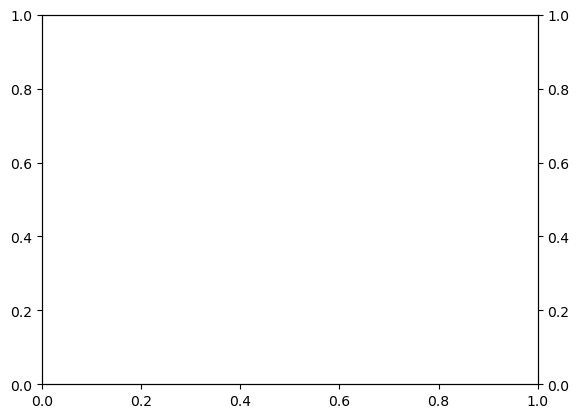

In [1]:
# 5. Confirm the Learning Process
%matplotlib inline 
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')  
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')  
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

In [ ]:
# 6. Using the Model
model.save('Lib_Reading_10Frame_Model.h5')